In [78]:
from pathlib import Path
import pandas as pd
import tarfile
import urllib.request

In [79]:
def load_housing_file():
  tarball_path = Path("datasets/housing.tgz")
  if not tarball_path.is_file():
    Path("datasets").mkdir(parents=True, exist_ok=True)
    url = 'https://github.com/ageron/data/raw/main/housing.tgz'
    urllib.request.urlretrieve(url, tarball_path)
    with tarfile.open(tarball_path) as housing_tarball:
      housing_tarball.extractall(path='datasets')
  return pd.read_csv("datasets/housing/housing.csv")

housing = load_housing_file()


In [80]:
housing.head()

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0    -122.23     37.88                41.0        880.0           129.0   
1    -122.22     37.86                21.0       7099.0          1106.0   
2    -122.24     37.85                52.0       1467.0           190.0   
3    -122.25     37.85                52.0       1274.0           235.0   
4    -122.25     37.85                52.0       1627.0           280.0   

   population  households  median_income  median_house_value ocean_proximity  
0       322.0       126.0         8.3252            452600.0        NEAR BAY  
1      2401.0      1138.0         8.3014            358500.0        NEAR BAY  
2       496.0       177.0         7.2574            352100.0        NEAR BAY  
3       558.0       219.0         5.6431            341300.0        NEAR BAY  
4       565.0       259.0         3.8462            342200.0        NEAR BAY

In [81]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [82]:
housing['ocean_proximity'].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [83]:
housing.describe()

longitude      latitude  housing_median_age   total_rooms  \
count  20640.000000  20640.000000        20640.000000  20640.000000   
mean    -119.569704     35.631861           28.639486   2635.763081   
std        2.003532      2.135952           12.585558   2181.615252   
min     -124.350000     32.540000            1.000000      2.000000   
25%     -121.800000     33.930000           18.000000   1447.750000   
50%     -118.490000     34.260000           29.000000   2127.000000   
75%     -118.010000     37.710000           37.000000   3148.000000   
max     -114.310000     41.950000           52.000000  39320.000000   

       total_bedrooms    population    households  median_income  \
count    20433.000000  20640.000000  20640.000000   20640.000000   
mean       537.870553   1425.476744    499.539680       3.870671   
std        421.385070   1132.462122    382.329753       1.899822   
min          1.000000      3.000000      1.000000       0.499900   
25%        296.000000    787.000000    280.000000       2.563400   
50%        435.000000   1166.000000    409.000000       3.534800   
75%        647.000000   1725.000000    605.000000       4.743250   
max       6445.000000  35682.000000   6082.000000      15.000100   

       median_house_value  
count        20640.000000  
mean        206855.816909  
std         115395.615874  
min          14999.000000  
25%         119600.000000  
50%         179700.000000  
75%         264725.000000  
max         500001.000000

In [84]:
IMAGES_PATH = Path() / "images" / "end_to_end"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extention='png', resulation=300):
  path = IMAGES_PATH / f'{fig_id}.{fig_extention}'
  if tight_layout:
    plt.tight_layout()
  plt.savefig(path, format=fig_extention, dpi=resulation)

In [85]:
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

housing.hist(bins=50, figsize=(12, 8))
save_fig('attibutes_hist_plot')
plt.show()

In [86]:
import numpy as np

def shuffled_and_split_data(data, test_ratio):
  shuffled_indices = np.random.permutation(len(data))
  test_set_size = int(len(data) * test_ratio)
  train_indices = shuffled_indices[:test_set_size]
  test_indices = shuffled_indices[test_set_size:]
  return data.iloc[train_indices], data.iloc[test_indices]

In [87]:
train_set, test_set = shuffled_and_split_data(housing, 0.2)
np.random.seed(42)

In [88]:
from zlib import crc32

def is_id_in_test_set(id, test_ratio):
  return crc32(np.int64(id)) < test_ratio * 2**32

def split_data_with_id_hash(data, test_ratio, id_column):
  ids = data[id_column]
  in_test_set = ids.apply(lambda id_ : is_id_in_test_set(id_, test_ratio))
  return data.loc[~in_test_set], data.loc[in_test_set]


In [89]:
housing_id = housing.reset_index()
train_set, test_set = split_data_with_id_hash(housing_id, 0.2, 'index')

In [90]:
housing_id["id"] = housing['longitude'] * 1000 + housing['latitude']
train_set, test_set = split_data_with_id_hash(housing_id, 0.2, "id")

In [91]:
from scipy.stats import binom

sample_size = 1000
ratio_female = 0.511

proba_too_small = binom(sample_size, ratio_female).cdf(485 - 1)
proba_too_large = 1 - binom(sample_size, ratio_female).cdf(535)
print(proba_too_large + proba_too_small)

0.10736798530929942


In [92]:
housing['median_income'].hist(rwidth=0.4, bins=5)

<Axes: >

In [93]:
housing['income_cat'] = pd.cut(housing['median_income'],
                               bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                               labels=[1, 2, 3, 4, 5])

In [94]:
housing["income_cat"].value_counts().sort_index().plot.bar(rot=0, grid=True)
plt.xlabel("Income category")
plt.ylabel("Number of districts")
save_fig("housing_income_cat_bar_plot")
plt.show()

In [95]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing['income_cat']):
  strat_train_set = housing.loc[train_index]
  strat_test_set = housing.loc[test_index]

In [96]:
for set_ in (strat_train_set, strat_test_set):
  set_.drop('income_cat', axis=1, inplace=True)

In [97]:
housing = strat_train_set.copy()

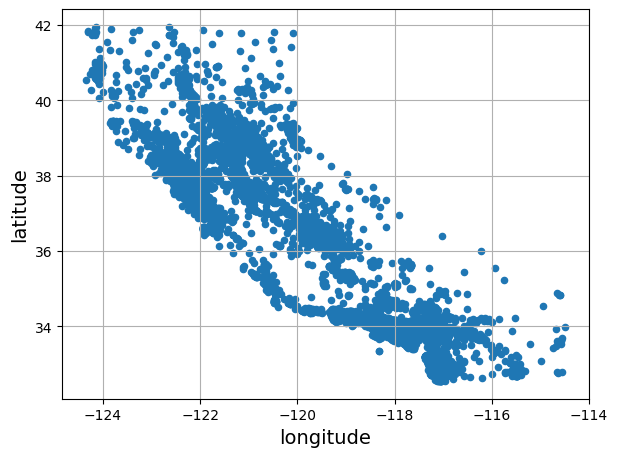

In [98]:
housing.plot(kind='scatter', x='longitude', y='latitude', grid=True)
save_fig("bad_visualization_plot")
plt.show()

In [99]:
housing.plot(kind='scatter', x='longitude', y='latitude', grid=True, alpha=0.2)
save_fig("better_visualization_plot")
plt.show()

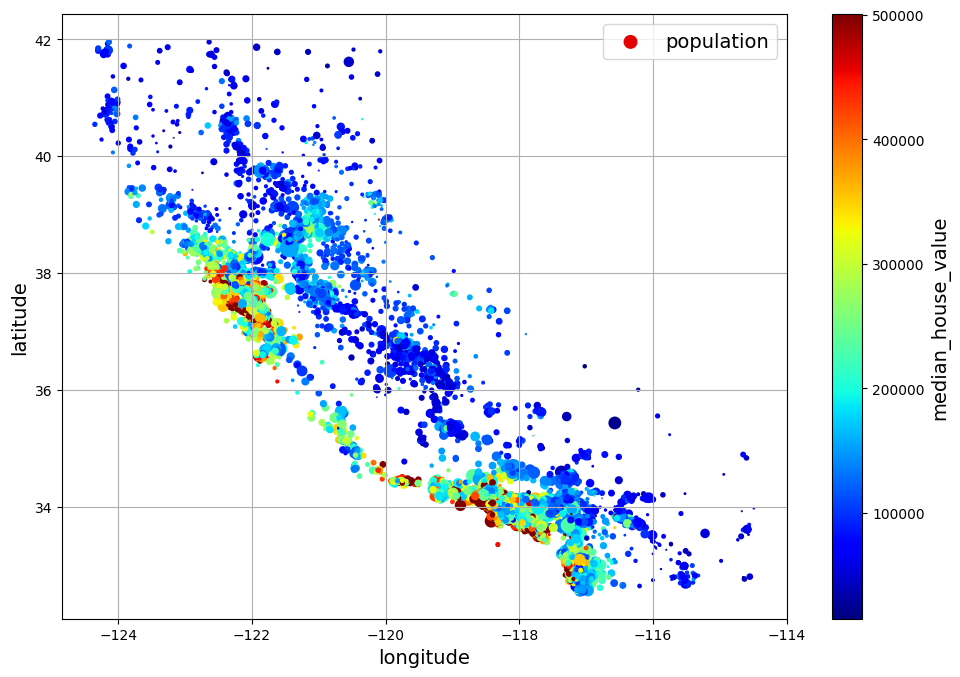

In [100]:
housing.plot(kind='scatter', x='longitude', y='latitude', grid=True, s=housing['population']/100, label='population', c='median_house_value', cmap='jet', colorbar=True, legend=True, sharex=False, figsize=(10, 7))
save_fig("housing_prices_scatterplot")
plt.show()

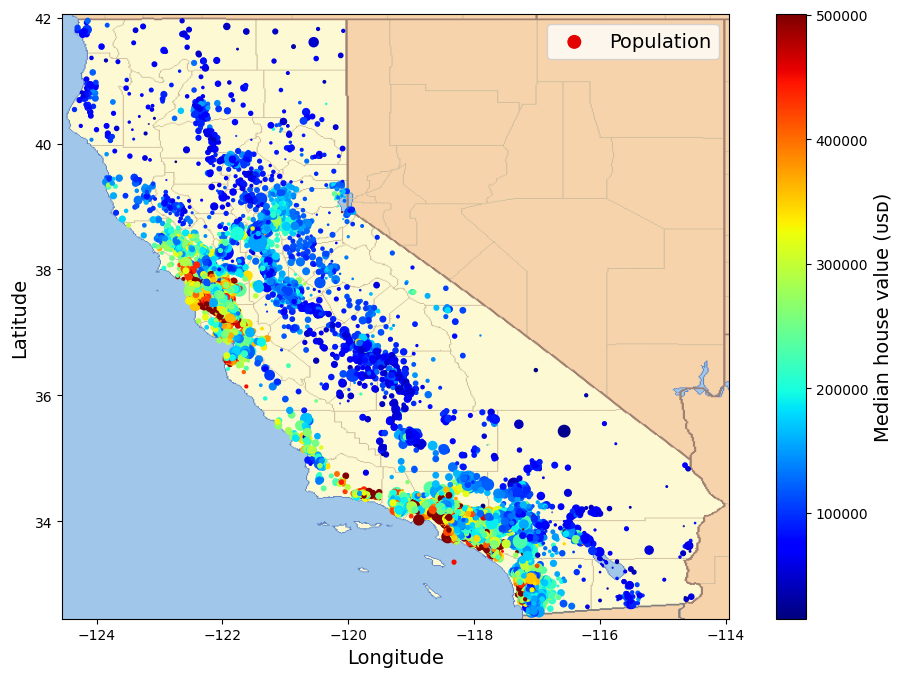

In [101]:
filename = "california.png"
if not (IMAGES_PATH / filename).is_file():
    homl3_root = "https://github.com/ageron/handson-ml3/raw/main/"
    url = homl3_root + "images/end_to_end_project/" + filename
    print("Downloading", filename)
    urllib.request.urlretrieve(url, IMAGES_PATH / filename)

housing_renamed = housing.rename(columns={
    "latitude": "Latitude", "longitude": "Longitude",
    "population": "Population",
    "median_house_value": "Median house value (ᴜsᴅ)"})
housing_renamed.plot(
             kind="scatter", x="Longitude", y="Latitude",
             s=housing_renamed["Population"] / 100, label="Population",
             c="Median house value (ᴜsᴅ)", cmap="jet", colorbar=True,
             legend=True, sharex=False, figsize=(10, 7))

california_img = plt.imread(IMAGES_PATH / filename)
axis = -124.55, -113.95, 32.45, 42.05
plt.axis(axis)
plt.imshow(california_img, extent=axis)

save_fig("california_housing_prices_plot")
plt.show()

In [102]:
corr_matrix = housing.corr()

<ipython-input-102-bac487469033>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = housing.corr()


In [103]:
corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.688380
total_rooms           0.137455
housing_median_age    0.102175
households            0.071426
total_bedrooms        0.054635
population           -0.020153
longitude            -0.050859
latitude             -0.139584
Name: median_house_value, dtype: float64

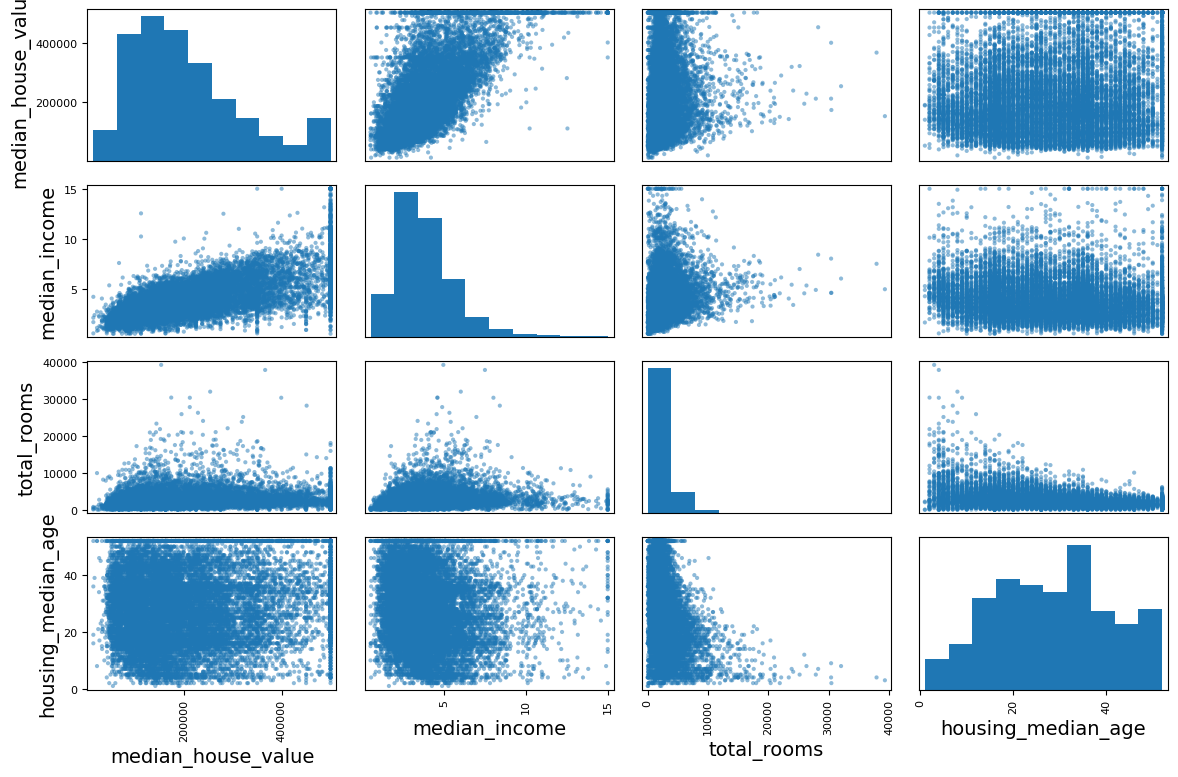

In [104]:
from pandas.plotting import scatter_matrix

attributes = ['median_house_value', 'median_income', 'total_rooms', 'housing_median_age']
scatter_matrix(housing[attributes], figsize=(12, 8))
save_fig("scatter_matrix_plot")  # extra code
plt.show()

In [105]:
housing["rooms_per_house"] = housing["total_rooms"] / housing["households"]
housing["bedrooms_ratio"] = housing["total_bedrooms"] / housing["total_rooms"]
housing["people_per_house"] = housing["population"] / housing["households"]

In [106]:
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

<ipython-input-106-51a0e6bf2eb4>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = housing.corr()


median_house_value    1.000000
median_income         0.688380
rooms_per_house       0.143663
total_rooms           0.137455
housing_median_age    0.102175
households            0.071426
total_bedrooms        0.054635
population           -0.020153
people_per_house     -0.038224
longitude            -0.050859
latitude             -0.139584
bedrooms_ratio       -0.256397
Name: median_house_value, dtype: float64

In [107]:
housing = strat_train_set.drop("median_house_value", axis=1)
housing_labels = strat_train_set['median_house_value'].copy()
housing_num = housing.drop('ocean_proximity', axis=1)

In [108]:
# housing.drapna(subset=['total_bedrooms'])
# housing.drop("total_bedrooms", axis=1)
median = housing['total_bedrooms'].median()
housing['total_bedrooms'].fillna(median, inplace=True)

In [109]:
null_rows_idx = housing.isnull().any(axis=1)
housing.loc[null_rows_idx].head()

Empty DataFrame
Columns: [longitude, latitude, housing_median_age, total_rooms, total_bedrooms, population, households, median_income, ocean_proximity]
Index: []

In [110]:
housing.head()

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
13096    -122.42     37.80                52.0       3321.0          1115.0   
14973    -118.38     34.14                40.0       1965.0           354.0   
3785     -121.98     38.36                33.0       1083.0           217.0   
14689    -117.11     33.75                17.0       4174.0           851.0   
20507    -118.15     33.77                36.0       4366.0          1211.0   

       population  households  median_income ocean_proximity  
13096      1576.0      1034.0         2.0987        NEAR BAY  
14973       666.0       357.0         6.0876       <1H OCEAN  
3785        562.0       203.0         2.4330          INLAND  
14689      1845.0       780.0         2.2618          INLAND  
20507      1912.0      1172.0         3.5292      NEAR OCEAN

In [111]:
housing['ocean_proximity'].value_counts()

<1H OCEAN     7274
INLAND        5301
NEAR OCEAN    2089
NEAR BAY      1846
ISLAND           2
Name: ocean_proximity, dtype: int64

In [112]:
housing_cat = housing[['ocean_proximity']]
from sklearn.preprocessing import OrdinalEncoder

incoder = OrdinalEncoder()
housing_cat_incoded = incoder.fit_transform(housing_cat)

In [113]:
housing_cat_incoded[:8]

array([[3.],
       [0.],
       [1.],
       [1.],
       [4.],
       [1.],
       [0.],
       [3.]])

In [114]:
incoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [115]:
from sklearn.preprocessing import OneHotEncoder

cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)

In [116]:
housing_cat_1hot


<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

In [117]:
housing_cat_1hot.toarray()


array([[0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.]])

In [118]:
cat_encoder = OneHotEncoder(sparse=False)
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


array([[0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.]])

In [119]:
df_test = pd.DataFrame({"ocean_proximity": ["INLAND", "NEAR BAY"]})
pd.get_dummies(df_test)

ocean_proximity_INLAND  ocean_proximity_NEAR BAY
0                       1                         0
1                       0                         1

In [120]:
cat_encoder.transform(df_test)


array([[0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0.]])

In [121]:
df_test_unknown = pd.DataFrame({"ocean_proximity": ["<2H OCEAN", "ISLAND"]})
pd.get_dummies(df_test_unknown)

ocean_proximity_<2H OCEAN  ocean_proximity_ISLAND
0                          1                       0
1                          0                       1

In [122]:
cat_encoder.handle_unknown = "ignore"
cat_encoder.transform(df_test_unknown)

array([[0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.]])

In [123]:
df_output = pd.DataFrame(cat_encoder.transform(df_test_unknown),
                         columns=cat_encoder.get_feature_names_out(),
                         index=df_test_unknown.index)

In [124]:
df_output


ocean_proximity_<1H OCEAN  ocean_proximity_INLAND  ocean_proximity_ISLAND  \
0                        0.0                     0.0                     0.0   
1                        0.0                     0.0                     1.0   

   ocean_proximity_NEAR BAY  ocean_proximity_NEAR OCEAN  
0                       0.0                         0.0  
1                       0.0                         0.0

In [125]:
from sklearn.base import BaseEstimator, TransformerMixin

# get the right column indices: safer than hard-coding indices 3, 4, 5, 6
rooms_ix, bedrooms_ix, population_ix, household_ix = [
    list(housing.columns).index(col)
    for col in ("total_rooms", "total_bedrooms", "population", "households")]

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True): # no *args or **kwargs
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self  # nothing else to do
    def transform(self, X, y=None):
        rooms_per_household = X[:, rooms_ix] / X[:, household_ix]
        population_per_household = X[:, population_ix] / X[:, household_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household,
                         bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)

In [126]:
from sklearn.preprocessing import FunctionTransformer

def add_extra_features(X, add_bedrooms_per_room=True):
    rooms_per_household = X[:, rooms_ix] / X[:, household_ix]
    population_per_household = X[:, population_ix] / X[:, household_ix]
    if add_bedrooms_per_room:
        bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
        return np.c_[X, rooms_per_household, population_per_household,
                     bedrooms_per_room]
    else:
        return np.c_[X, rooms_per_household, population_per_household]

attr_adder = FunctionTransformer(add_extra_features, validate=False,
                                 kw_args={"add_bedrooms_per_room": False})
housing_extra_attribs = attr_adder.fit_transform(housing.values)

In [127]:
housing_extra_attribs = pd.DataFrame(
    housing_extra_attribs,
    columns=list(housing.columns)+["rooms_per_household", "population_per_household"],
    index=housing.index)
housing_extra_attribs.head()

longitude latitude housing_median_age total_rooms total_bedrooms  \
13096   -122.42     37.8               52.0      3321.0         1115.0   
14973   -118.38    34.14               40.0      1965.0          354.0   
3785    -121.98    38.36               33.0      1083.0          217.0   
14689   -117.11    33.75               17.0      4174.0          851.0   
20507   -118.15    33.77               36.0      4366.0         1211.0   

      population households median_income ocean_proximity rooms_per_household  \
13096     1576.0     1034.0        2.0987        NEAR BAY            3.211799   
14973      666.0      357.0        6.0876       <1H OCEAN            5.504202   
3785       562.0      203.0         2.433          INLAND            5.334975   
14689     1845.0      780.0        2.2618          INLAND            5.351282   
20507     1912.0     1172.0        3.5292      NEAR OCEAN            3.725256   

      population_per_household  
13096                 1.524178  
14973                 1.865546  
3785                  2.768473  
14689                 2.365385  
20507                 1.631399

In [128]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('attribs_adder', FunctionTransformer(add_extra_features, validate=False)),
        ('std_scaler', StandardScaler()),
    ])

housing_num_tr = num_pipeline.fit_transform(housing_num)

In [129]:
try:
    from sklearn.compose import ColumnTransformer
except ImportError:
    from future_encoders import ColumnTransformer # Scikit-Learn < 0.20

In [130]:
num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", OneHotEncoder(), cat_attribs),
    ])

housing_prepared = full_pipeline.fit_transform(housing)

In [131]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

LinearRegression()

In [132]:
some_data = housing.iloc[:5]
some_labels = housing_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)

print("Predictions:", lin_reg.predict(some_data_prepared))

Predictions: [276608.27419651 333603.0303772  118237.5726011  108255.75159886
 308943.82732346]


In [133]:
print("Labels:", list(some_labels))

Labels: [458300.0, 483800.0, 101700.0, 96100.0, 361800.0]


In [134]:
some_data_prepared

array([[-1.42303652,  1.0136059 ,  1.86111875,  0.31191221,  1.36816703,
         0.13746004,  1.39481249, -0.93649149, -0.86602737, -0.33020372,
         1.84662439,  0.        ,  0.        ,  0.        ,  1.        ,
         0.        ],
       [ 0.59639445, -0.702103  ,  0.90762971, -0.30861991, -0.43592476,
        -0.69377062, -0.37348471,  1.17194198,  0.0245495 , -0.25361631,
        -0.5081207 ,  1.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [-1.2030985 ,  1.27611874,  0.35142777, -0.71224036, -0.76070869,
        -0.78876841, -0.77572662, -0.75978881, -0.04119332, -0.05104091,
        -0.20215476,  0.        ,  1.        ,  0.        ,  0.        ,
         0.        ],
       [ 1.23121557, -0.88492444, -0.91989094,  0.70226169,  0.74230601,
         0.38317548,  0.73137454, -0.85028088, -0.03485833, -0.14147547,
        -0.14900562,  0.        ,  1.        ,  0.        ,  0.        ,
         0.        ],
       [ 0.71136206, -0.87554898,  0

In [135]:
from sklearn.metrics import mean_squared_error

housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

67769.12117461127

In [136]:
from sklearn.metrics import mean_absolute_error

lin_mae = mean_absolute_error(housing_labels, housing_predictions)
lin_mae

49190.60052737819

In [137]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor(random_state=42)
tree_reg.fit(housing_prepared, housing_labels)

DecisionTreeRegressor(random_state=42)

In [138]:
housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.0

In [139]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(tree_reg, housing_prepared, housing_labels, scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)

In [140]:
def display_scores(scores):
  print("scores: ", scores)
  print("mean: ", scores.mean())
  print("standard deviation: ", scores.std())

In [141]:
display_scores(tree_rmse_scores)

scores:  [68179.7164381  67258.55627212 66747.10876197 72757.66827765
 69428.86115501 69925.32535691 72349.29057653 73190.09810575
 70307.13891453 70553.57614878]
mean:  70069.73400073592
standard deviation:  2130.605601030783


In [142]:
lin_scores = cross_val_score(lin_reg, housing_prepared, housing_labels, scoring="neg_mean_squared_error", cv=10)

In [143]:
lin_rmse_scores = np.sqrt(-lin_scores)

In [144]:
display_scores(lin_rmse_scores)

scores:  [69717.57852026 66650.26617871 66488.43193213 70478.22519838
 66837.93229332 68220.31091521 66922.70445332 69700.47781664
 67122.26131607 67802.47918508]
mean:  67994.06678091262
standard deviation:  1394.937701550329


In [145]:
from sklearn.ensemble import RandomForestRegressor
forest_reg = RandomForestRegressor()
forest_reg.fit(housing_prepared, housing_labels)

RandomForestRegressor()

In [146]:
housing_predictions = forest_reg.predict(housing_prepared)
forest_mse = mean_squared_error(housing_labels, housing_predictions)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

18500.845182815105

In [147]:
forest_rmse_scores = np.sqrt(-(cross_val_score(forest_reg, housing_prepared, housing_labels, scoring="neg_mean_squared_error", cv=10)))

In [148]:
display_scores(forest_rmse_scores)

scores:  [48647.91264047 49885.13920025 47900.56476154 50215.95773715
 48861.68076561 49932.02979263 50239.90265081 51395.10435194
 49958.8024506  49654.38044803]
mean:  49669.14747990363
standard deviation:  928.7828363639626


In [149]:
import joblib
joblib.dump(forest_reg, "forest.pkl")

['forest.pkl']

In [150]:
from sklearn.svm import SVR

svm_reg = SVR(kernel="linear")
svm_reg.fit(housing_prepared, housing_labels)
housing_predictions = svm_reg.predict(housing_prepared)
svm_mse = mean_squared_error(housing_labels, housing_predictions)
svm_rmse = np.sqrt(svm_mse)
svm_rmse

110578.44384464291

In [151]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    {'n_estimators':[3, 10, 30], 'max_features':[2, 4, 6, 8]},
    {'bootstrap':[False], 'n_estimators':[3, 10], 'max_features':[2, 3, 4]}
]
forest_reg = RandomForestRegressor()
grid_search = GridSearchCV(forest_reg, param_grid, cv=5, scoring='neg_mean_squared_error', return_train_score=True)

grid_search.fit(housing_prepared, housing_labels)

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid=[{'max_features': [2, 4, 6, 8],
                          'n_estimators': [3, 10, 30]},
                         {'bootstrap': [False], 'max_features': [2, 3, 4],
                          'n_estimators': [3, 10]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [152]:
grid_search.best_params_

{'max_features': 8, 'n_estimators': 30}

In [153]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
  print(np.sqrt(-mean_score), params)

63459.27619253469 {'max_features': 2, 'n_estimators': 3}
55164.86085829575 {'max_features': 2, 'n_estimators': 10}
52456.71065078031 {'max_features': 2, 'n_estimators': 30}
60178.78887551771 {'max_features': 4, 'n_estimators': 3}
52189.15052913794 {'max_features': 4, 'n_estimators': 10}
50087.42036303565 {'max_features': 4, 'n_estimators': 30}
57925.9085740699 {'max_features': 6, 'n_estimators': 3}
52089.190598021065 {'max_features': 6, 'n_estimators': 10}
50107.75465078326 {'max_features': 6, 'n_estimators': 30}
59155.21719086341 {'max_features': 8, 'n_estimators': 3}
51939.85428773961 {'max_features': 8, 'n_estimators': 10}
49921.831358560914 {'max_features': 8, 'n_estimators': 30}
61213.407108789055 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
53552.24632083385 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
59694.41176478658 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
52371.03248525344 {'bootstrap': False, 'max_features': 3, 'n_estimators': 

In [154]:
from sklearn.model_selection import RandomizedSearchCV

from scipy.stats import randint
param_distribs = {
    'n_estimators': randint(low=1, high=200),
    'max_features': randint(low=1, high=8)
}
forest_reg = RandomForestRegressor(random_state=42)
rnd_search = RandomizedSearchCV(forest_reg, param_distributions=param_distribs, n_iter=10, cv=5, scoring='neg_mean_squared_error', random_state=42)
rnd_search.fit(housing_prepared, housing_labels)

RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
                   param_distributions={'max_features': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x79342448b430>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x79342448b790>},
                   random_state=42, scoring='neg_mean_squared_error')

In [155]:
rnd_search.best_params_

{'max_features': 7, 'n_estimators': 180}

In [156]:
cvres = rnd_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

48817.07237111398 {'max_features': 7, 'n_estimators': 180}
51124.368841786425 {'max_features': 5, 'n_estimators': 15}
50295.19999459879 {'max_features': 3, 'n_estimators': 72}
50497.3939287014 {'max_features': 5, 'n_estimators': 21}
48905.78551167292 {'max_features': 7, 'n_estimators': 122}
50282.233508532976 {'max_features': 3, 'n_estimators': 75}
50039.318321106344 {'max_features': 3, 'n_estimators': 88}
49118.457451549664 {'max_features': 5, 'n_estimators': 100}
49892.18228479081 {'max_features': 3, 'n_estimators': 150}
65003.603277711685 {'max_features': 5, 'n_estimators': 2}


In [160]:
feature_importances = rnd_search.best_estimator_.feature_importances_
feature_importances

array([7.27088430e-02, 6.53044432e-02, 4.22284405e-02, 1.64101011e-02,
       1.58082870e-02, 1.60642763e-02, 1.45572730e-02, 3.43044824e-01,
       5.74036886e-02, 1.10625085e-01, 6.98657735e-02, 9.32529277e-03,
       1.59929813e-01, 1.49561128e-04, 2.54642029e-03, 4.02787760e-03])

In [161]:
extra_attribs = ["rooms_per_hhold", "pop_per_hhold", "bedrooms_per_room"]
#cat_encoder = cat_pipeline.named_steps["cat_encoder"] # old solution
cat_encoder = full_pipeline.named_transformers_["cat"]
cat_one_hot_attribs = list(cat_encoder.categories_[0])
attributes = num_attribs + extra_attribs + cat_one_hot_attribs
sorted(zip(feature_importances, attributes), reverse=True)

[(0.3430448241477668, 'median_income'),
 (0.1599298129068833, 'INLAND'),
 (0.11062508509084949, 'pop_per_hhold'),
 (0.07270884300291978, 'longitude'),
 (0.06986577353004325, 'bedrooms_per_room'),
 (0.06530444316933467, 'latitude'),
 (0.05740368855504742, 'rooms_per_hhold'),
 (0.04222844051445, 'housing_median_age'),
 (0.01641010108335831, 'total_rooms'),
 (0.016064276299525733, 'population'),
 (0.01580828696340606, 'total_bedrooms'),
 (0.014557272953511322, 'households'),
 (0.009325292769013135, '<1H OCEAN'),
 (0.004027877599405326, 'NEAR OCEAN'),
 (0.002546420286772734, 'NEAR BAY'),
 (0.00014956112771276383, 'ISLAND')]

In [162]:
final_model = rnd_search.best_estimator_
final_model

RandomForestRegressor(max_features=7, n_estimators=180, random_state=42)

In [163]:
X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()

X_test_prepared = full_pipeline.transform(X_test)

final_predictions = final_model.predict(X_test_prepared)

final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)

In [164]:
final_rmse

48956.230244397164

In [166]:
from scipy import stats
confidence = 0.95
squared_errors = (final_predictions - y_test) ** 2
np.sqrt(stats.t.interval(confidence, len(squared_errors) - 1, loc=squared_errors.mean(), scale=stats.sem(squared_errors)))


array([46624.10334748, 51182.20341611])

#practice

In [169]:
from sklearn.model_selection import GridSearchCV

param_grid = [
        {'kernel': ['linear'], 'C': [10., 30., 100., 300., 1000., 3000., 10000., 30000.0]},
        {'kernel': ['rbf'], 'C': [1.0, 3.0, 10., 30., 100., 300., 1000.0],
         'gamma': [0.01, 0.03, 0.1, 0.3, 1.0, 3.0]},
    ]

svm_reg = SVR()
grid_search = GridSearchCV(svm_reg, param_grid, cv=3, scoring='neg_mean_squared_error', verbose=3, n_jobs=2)
grid_search.fit(housing_prepared, housing_labels)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


KeyboardInterrupt: ignored

In [170]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import expon, reciprocal

# see https://docs.scipy.org/doc/scipy/reference/stats.html
# for `expon()` and `reciprocal()` documentation and more probability distribution functions.

# Note: gamma is ignored when kernel is "linear"
param_distribs = {
        'kernel': ['linear', 'rbf'],
        'C': reciprocal(20, 200000),
        'gamma': expon(scale=1.0),
    }

svm_reg = SVR()
rnd_search = RandomizedSearchCV(svm_reg, param_distributions=param_distribs,
                                n_iter=50, cv=5, scoring='neg_mean_squared_error',
                                verbose=2, n_jobs=4, random_state=42)
rnd_search.fit(housing_prepared, housing_labels)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


KeyboardInterrupt: ignored